This notebook is credited to the hard work of [Aurélien Geron](https://github.com/ageron); based on the second edition of his [book](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) Hands-On Machine Learning with Scikit-Learn, Kera and Tensorflow.

# Outline
### 1. [Frame the probelm and Look at the Big Picture ](#1)
### 2. [Get the Data](#2)
### 3. [Explore the data to gain insights](#3)
### 4. [Prepare the data to better expose the underlying patterns to Machine Learning algorithms](#4)
### 5. [Explore many different models and short-list the best ones](#5)
### 6. [Fine-tune your models and combine them into a great solution](#6)
### 7. [Present your solution](#7)
### 8. [Launch, monitor, and maintain your system](#8)

<a name="1"></a>
## 1. Frame the Problem and Look at the Big Picture.
* Build a model of housing prices in California using the California census data.\
This data has metrics such as the population, median income, median housing price,\
and so on for each block group in California.

* Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data.

* A block group typically has a population of 600 to 3,000 people.

* We will just call them “districts” for short.

* Your model should learn from this data and be able to predict the median housing price in any district, given all the other metrics.

## Setup
Let's install the libraries we'll be using in this project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV, GridSearchCV
import matplotlib.image as mpimg
from PIL import Image
from urllib.request import urlopen
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from sklearn.metrics import mean_squared_error

# To get the data
from sklearn.datasets import fetch_openml

<a name='2'></a>
## 2. Get the Data

In [2]:
# Fetch the data from openml as a Dataframe.
data = fetch_openml(data_id=43939, as_frame=True)

/home/jp/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


<a name='2'></a>
## 3. Explore the data to gain insights

In [3]:
# Concatonate the features and target Dataframes into one Dataframe.
housing = pd.concat([data['data'], data['target']], axis=1)
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income ocean_proximity  median_house_value  
0       322.0       126.0         8.3252        NEAR BAY            452600.0  
1      2401.0      1138.0         8.3014        NEAR BAY            358500.0  
2       496.0       177.0         7.2574        NEAR BAY            352100.0  
3       558.0       219.0         5.6431        NEAR BAY            341300.0  
4       565.0       259.0         3.8462        NEAR BAY            342200.0

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  float64 
 6   households          20640 non-null  float64 
 7   median_income       20640 non-null  float64 
 8   ocean_proximity     20640 non-null  category
 9   median_house_value  20640 non-null  float64 
dtypes: category(1), float64(9)
memory usage: 1.4 MB


In [5]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [6]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

In [47]:
# Describe the categorical attributes.
housing.describe(exclude=np.number)

ocean_proximity
count            16512
unique               5
top          <1H OCEAN
freq              7277

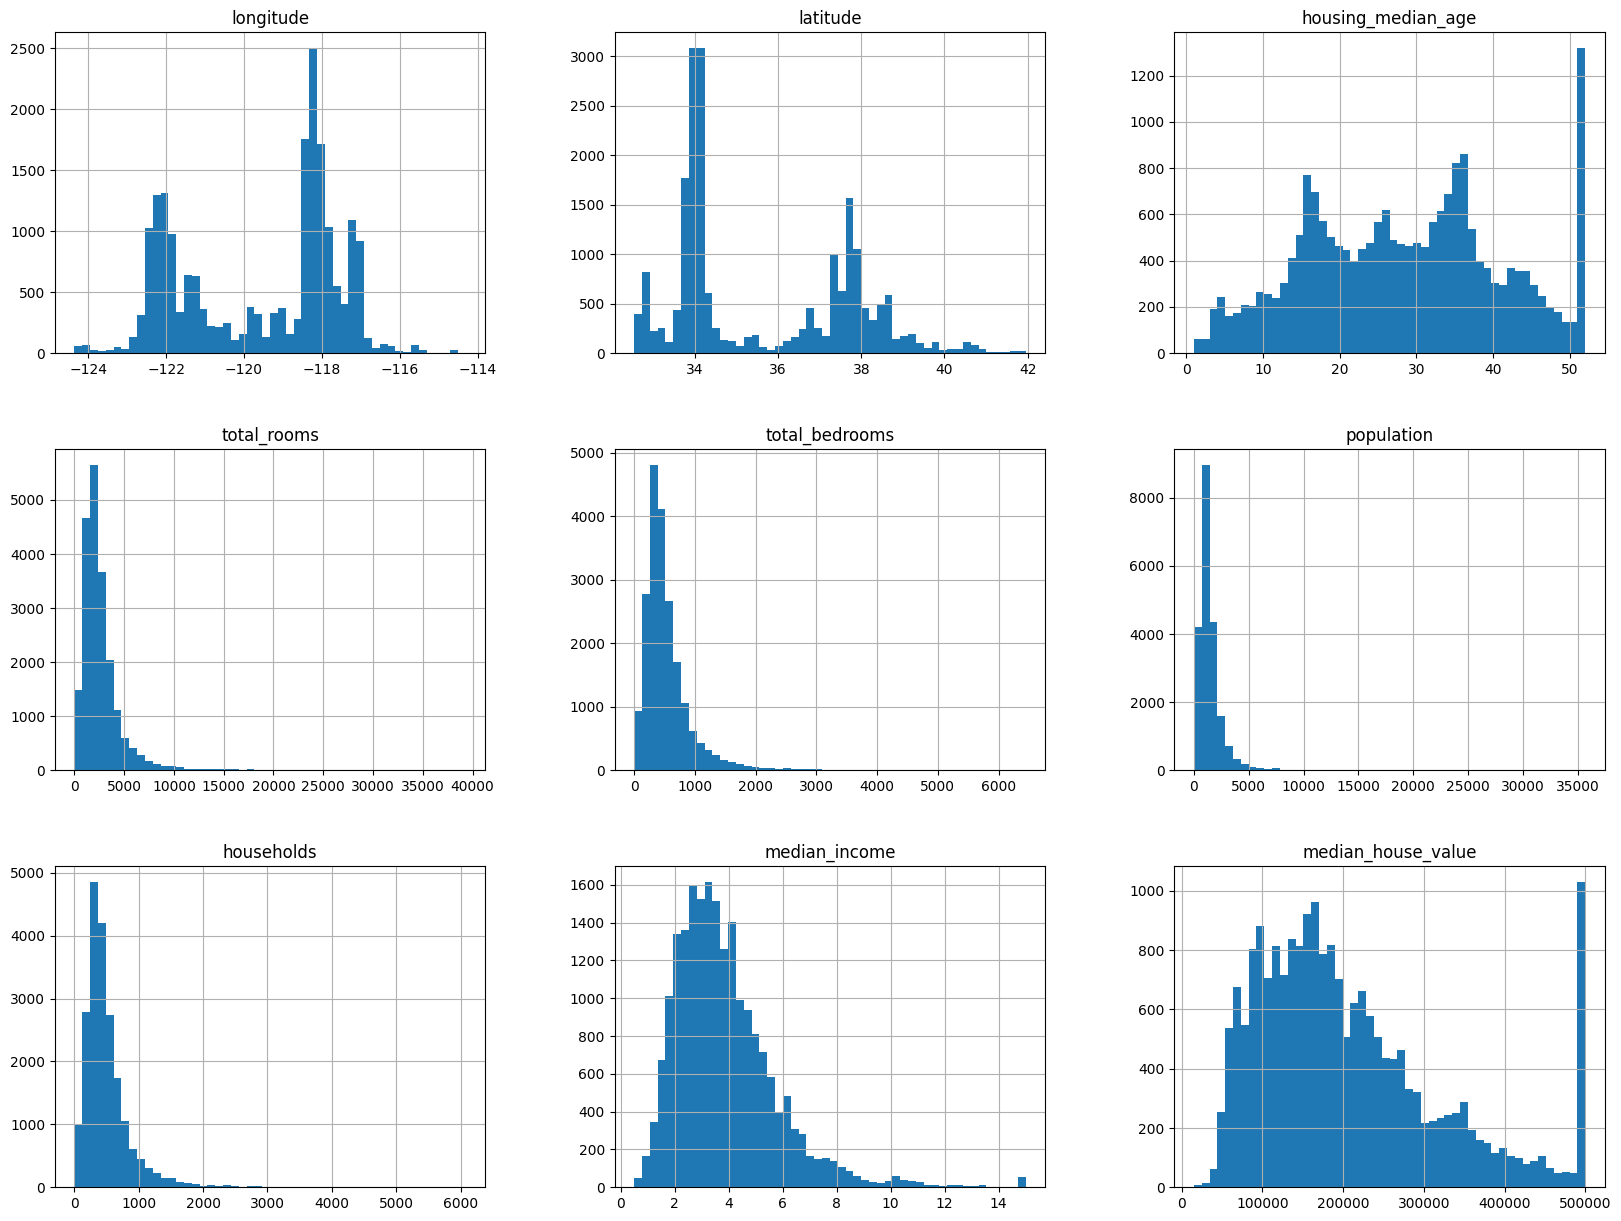

In [7]:
# Let's plot a histogram for each numerical attribue.
# %matplotlib inline is s jupyter's magic command; it tells Matplotlib to use jupyter's own backend for the plot.
%matplotlib inline 
housing.hist(bins=50, figsize=(20,15))
plt.show() # Optional in a jupyter notebook

### List of transformation that will be applied to the dataset to get it ready for the machine learning model.
- The `median_house_value` will be the target variable `y` & the rest will be the features in `X`.
- The `total_berooms` attribute has only 20433 non-null values. So, 207 districts are missing this feature.
- The `ocean_proximity` attribute is a categorical feature with five unique values. We will one hot encode it.

### Create a Test Set

In [8]:
# to make this notebook's output identical at every run
np.random.seed(51)

- We want to ensure that our train and test sets are stratified based on an attibute that can best predict the median housing prices.
- The `median_income` seems to be a good candidate. It is a continuos numercal attribute.
- So we'll create an income category attribute using the `median_icome`.

<Axes: >

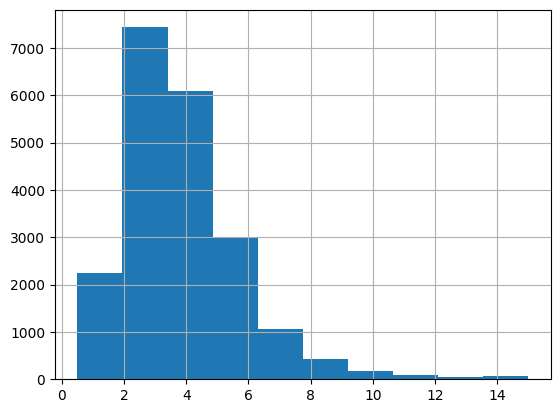

In [9]:
# Let's take a closer look at the median_income histogram.
housing["median_income"].hist()

- When creating the income category, we need to ensure that each starum is sufficiently represented\
to prevent sampling bias.
- So, we should not have too many strata and each stratum should be large enough.
- Our income category attribute will have 5 categories (labeled from 1 to 5).
    - Category 1 range: 1 - 1.5
    - Category 2 range: 1.5 - 3.0
    - Category 3 range: 3.0 - 4.5
    - Category 4 range: 4.5 - 6
    - Category 5 range: 6 - `np.inf`

In [10]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf],
                               labels=[1, 2, 3, 4, 5])

In [11]:
housing["income_cat"].value_counts()

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

<Axes: >

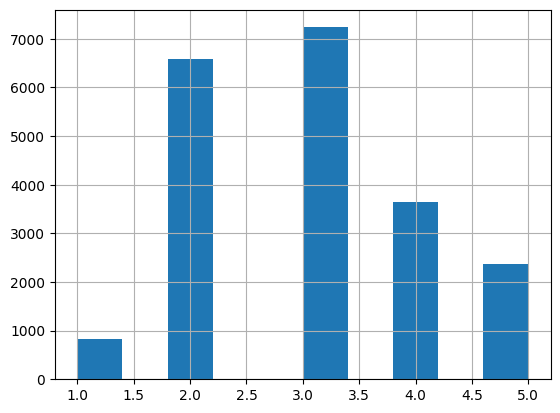

In [12]:
housing["income_cat"].hist()

In [13]:
# Split the data based on the income category.
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [14]:
# Remove the income category attribute after the transformation.
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Data Visualization

In [15]:
housing = strat_train_set.copy()

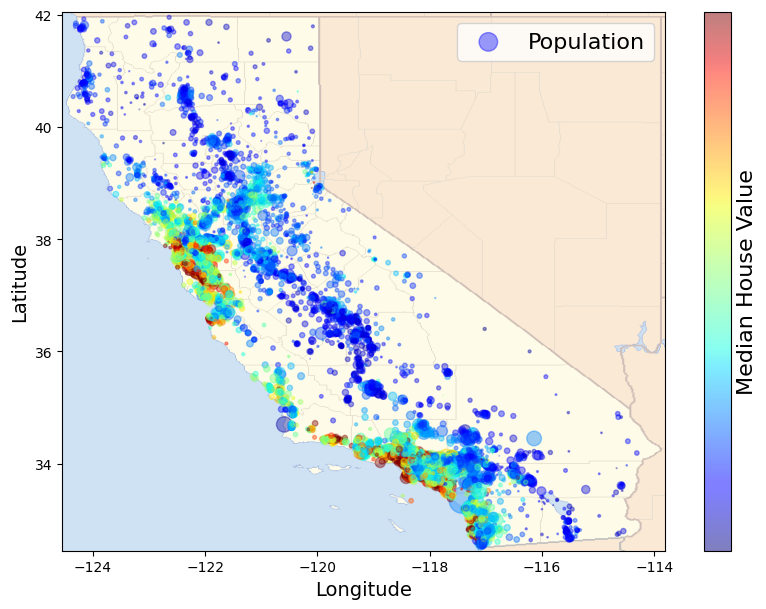

In [16]:
url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/images/end_to_end_project/california.png"

california_img=Image.open(urlopen(url))

ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

### Looking for Correlations

In [17]:
corr_matrix = housing.corr(numeric_only=True)

In [18]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

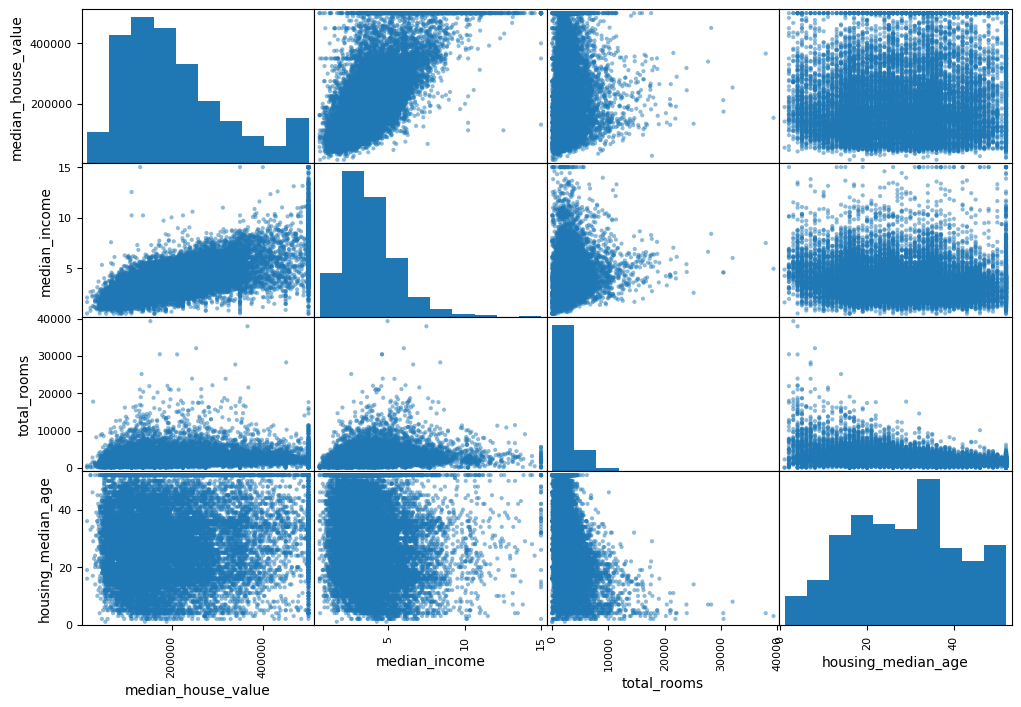

In [19]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

There seems to be a strong correlation between the median income and the median house value.\
Let's investigate further with a plot.

(0.0, 16.0, 0.0, 550000.0)

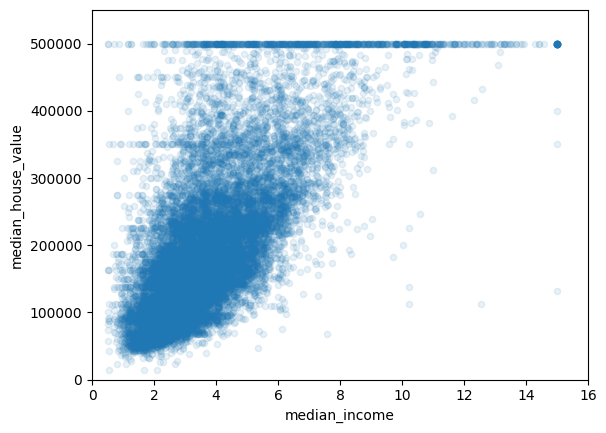

In [20]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

### Prepare the Data for Machine Learning Algorithms

In [21]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [22]:
# Choose how we are going to fill in the missing values for each attributes.
imputer = SimpleImputer(strategy="median")

In [23]:
# Perform the transformation on numerical data only.
housing_num = housing.select_dtypes(include=[np.number])

In [24]:
# Fill in the missing values of each feature with its median.
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [25]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [26]:
X = imputer.transform(housing_num)

In [27]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [28]:
housing_tr.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0       5320.0           855.0   
2908     -119.04     35.37                44.0       1618.0           310.0   
14053    -117.13     32.75                24.0       1877.0           519.0   
20496    -118.70     34.28                27.0       3536.0           646.0   

       population  households  median_income  
12655      2237.0       706.0         2.1736  
15502      2015.0       768.0         6.3373  
2908        667.0       300.0         2.8750  
14053       898.0       483.0         2.2264  
20496      1837.0       580.0         4.4964

### Handling Categorical Attributes

In [29]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

ocean_proximity
12655          INLAND
15502      NEAR OCEAN
2908           INLAND
14053      NEAR OCEAN
20496       <1H OCEAN
1481         NEAR BAY
18125       <1H OCEAN
5830        <1H OCEAN
17989       <1H OCEAN
4861        <1H OCEAN

In [30]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Custom Transformers

In [31]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [32]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

longitude latitude housing_median_age total_rooms total_bedrooms  \
12655   -121.46    38.52               29.0      3873.0          797.0   
15502   -117.23    33.09                7.0      5320.0          855.0   
2908    -119.04    35.37               44.0      1618.0          310.0   
14053   -117.13    32.75               24.0      1877.0          519.0   
20496    -118.7    34.28               27.0      3536.0          646.0   

      population households median_income ocean_proximity rooms_per_household  \
12655     2237.0      706.0        2.1736          INLAND            5.485836   
15502     2015.0      768.0        6.3373      NEAR OCEAN            6.927083   
2908       667.0      300.0         2.875          INLAND            5.393333   
14053      898.0      483.0        2.2264      NEAR OCEAN            3.886128   
20496     1837.0      580.0        4.4964       <1H OCEAN            6.096552   

      population_per_household  
12655                 3.168555  
15502                 2.623698  
2908                  2.223333  
14053                 1.859213  
20496                 3.167241

### Transformatin Pipelines

In [33]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [34]:
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

In [35]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [36]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [37]:
housing_prepared.shape

(16512, 16)

## Explore a few different models.

#### 1. Linear Regression.

In [38]:
# Train the Linear Regression model.
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [39]:
# Evaluate the Linear Regression model.
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)

lin_rmse_scores.mean()

69104.07998247063

#### 2. Decision Tree.

In [40]:
# Train the Decision Tree model.
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [42]:
# Evaluate the Decision Tree model.
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

tree_rmse_scores.mean()

71629.89009727491

#### 3. Random Forest.

In [43]:
# Train the Random Forest model.
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=51)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=51)

In [44]:
# Evaluate the Random Forest model.
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

forest_rmse_scores.mean()

50281.5031556387

#### 4. Suport Vector Machine

In [45]:
# Train the SVM model.
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)

SVR(kernel='linear')

In [46]:
# Evaluate the SVM model.
svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-svm_scores)

svm_rmse_scores.mean()

111814.1069260169

#### 5. XGBoost.

In [57]:
import xgboost as xgb

# Create regression matrices
dtrain_reg = xgb.DMatrix(housing_prepared, housing_labels, enable_categorical=True)
# dtest_reg = xgb.DMatrix(X_eval, y_eval, enable_categorical=True)

In [52]:
# Set the XGBoost model's parameters.
param = {'max_depth': 2, 'eta': 1}

# Train the model.
num_round = 1000
bst = xgb.cv(param, dtrain_reg, num_round, nfold=10)

In [59]:
bst['test-rmse-mean'].min()

49949.58902864145

#### 6. Neural Network

In [60]:
# Plot the mean of model's evaluation scores for all the models.
models_names = ['Linear', 'Tree', 'Forest', 'SVM', 'XGBoost']
models_scores = [lin_rmse_scores.mean(), tree_rmse_scores.mean(), forest_rmse_scores.mean(), svm_rmse_scores.mean(), bst['test-rmse-mean'].min()]

In [61]:
import plotly.express as px

df = pd.DataFrame(dict(
    Models = models_names,
    Scores = models_scores
))
fig = px.line(df, x="Models", y="Scores", markers=True, title="Mean of Models' evaluation scores")
fig.show()

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

### Randomize Search

In [ ]:
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
        'max_depth': randint(low=10, high=110),
        'min_samples_split': [2, 5, 10],
        'bootstrap': [True, False]
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb60a59bd90>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb60a598880>,
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb60a59a830>},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
np.sqrt(-rnd_search.best_score_)

48617.276920945806

In [ ]:
rnd_search.best_params_

{'bootstrap': False,
 'max_depth': 73,
 'max_features': 4,
 'min_samples_split': 2,
 'n_estimators': 161}

#### Grid Search

#### A full pipeline with both preparation and prediction

In [ ]:
param_grid = [
    {
        'bootstrap': [False],
        'max_depth': [80, 90, 100, 110],
        'max_features': [4],
        'min_samples_split': [2],
        'n_estimators': [161]
    }
]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'bootstrap': [False], 'max_depth': [80, 90, 100, 110],
                          'max_features': [4], 'min_samples_split': [2],
                          'n_estimators': [161]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
np.sqrt(-grid_search.best_score_)

48617.276920945806

### Evaluate the Model on the Test Set

In [ ]:
# final_model = grid_search.best_estimator_

# X_test = strat_test_set.drop("median_house_value", axis=1)
# y_test = strat_test_set["median_house_value"].copy()

# X_test_prepared = full_pipeline.transform(X_test)
# final_predictions = final_model.predict(X_test_prepared)

# final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
# final_rmse

46174.85550779615